- [visiualize center loss MNIST](https://github.com/jxgu1016/MNIST_center_loss_pytorch)
### Detail
- paper [here](http://ydwen.github.io/papers/WenECCV16.pdf)
- not just separate but discriminate 
- softmax loss = cross entrophy
- dataset MegaFace also [Labeled Faces in the Wild (LFW), and YouTube Faces (YTF)]
- use 5 landmarks (two eyes, nose and mouth corners) for similarity transformation by this [algorithm](https://arxiv.org/pdf/1604.02878.pdf)
- cropped to 112 × 96

TODO
- pretrain with softmax loss
- MTCNN to face align
- freeze/unfreeze
- 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from exitai.learner import Learner
from exitai.callbacks import Callback
from exitai.losses import CenterLoss
from sklearn.decomposition import PCA
import numpy as np
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class TestDataset(Dataset):
    def __init__(self, dataset, length=10):
        self.dataset = dataset
        self.length = length
    def __getitem__(self, index):
        return random.choice(self.dataset)
    def __len__(self):
        return self.length

In [4]:
transform_train = transforms.Compose([
#                                    transforms.RandomAffine(15, scale=(.9,1.2)), # TODO add me
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
dataset_train = datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train)
dataset_test = datasets.MNIST(root='../../data/', train=False, download=True, transform=transform_test)
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc_1 = nn.Linear(4*4*50, 500)
        self.fc_embedding = nn.Linear(500, 2)
        self.fc_classes = nn.Linear(2, 10)
        
    def forward(self, x):
        output = self.cnn(x)
        output = output.view(-1, 50*4*4)
        output = self.fc_1(output)
        vector_embedding = self.fc_embedding(output)
        output = self.fc_classes(vector_embedding)
        return output, vector_embedding
    
    def name(self):
        return "LeNet"

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.prelu1_1 = nn.PReLU()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.prelu1_2 = nn.PReLU()
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.prelu2_1 = nn.PReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.prelu2_2 = nn.PReLU()
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.prelu3_1 = nn.PReLU()
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.prelu3_2 = nn.PReLU()
        self.preluip1 = nn.PReLU()
        self.ip1 = nn.Linear(128*3*3, 2)
        self.ip2 = nn.Linear(2, 10, bias=False)

    def forward(self, x):
        x = self.prelu1_1(self.conv1_1(x))
        x = self.prelu1_2(self.conv1_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = F.max_pool2d(x,2)
        x = x.view(-1, 128*3*3)
        vector_embedding = self.preluip1(self.ip1(x))
        output = self.ip2(vector_embedding)
        return output, vector_embedding

In [7]:
def visualize(vectors_embedding, target, epoch):
    plt.ion()
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    plt.clf()
    for i in range(10):
        plt.plot(vectors_embedding[target == i, 0], vectors_embedding[target == i, 1], '.', c=c[i])
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc = 'upper right')
    plt.xlim(xmin=-80,xmax=80)
    plt.ylim(ymin=-80,ymax=80)
    plt.text(-7.8,7.3,"epoch=%d" % epoch)
#     plt.savefig('./images/epoch=%d.jpg' % epoch)
    plt.draw()
    plt.pause(0.001)

In [8]:
class Plottracker(Callback):
    def __init__(self):
        self.target = []
        self.vectors_embedding = []
        self.epoch = 0
        
    def add(self, target, vector_embedding):
        self.target.append((target))
        self.vectors_embedding.append((vector_embedding))
        
    def on_epoch_end(self, phase, num_data):
        vectors_embedding = torch.cat(self.vectors_embedding, 0)
        targets = torch.cat(self.target, 0)
        self.epoch += 1
        visualize(vectors_embedding.data.cpu().numpy(), targets.data.cpu().numpy(), self.epoch)

In [9]:
plottracker = Plottracker()
center_loss = CenterLoss(10, 2).to(device)
def model_loss_func(input_data, model, phase):
    input, target = input_data
    output, vector_embedding = model(input)
    plottracker.add(target, vector_embedding)
    
    # Loss
    loss = F.cross_entropy(output, target) #+ 0.01*center_loss(target, vector_embedding)
    return output, loss

In [10]:
###### Learning Rate Finder ######

# model = LeNet()
# learner = Learner(data_loader_train, data_loader_test, model)
# learner.lr_find(model_loss_func, 1e-7, 0.3)

In [11]:
class CenterLossOptimHook(Callback):
    def __init__(self):
        self.optim = torch.optim.SGD(center_loss.parameters(), lr=0.05)
    def on_batch_end(self, phase, input_data, output, loss):
        if phase is 'train':
            self.optim.step()
            self.optim.zero_grad()
            

---- epoch:0 ------
   [train] Average loss: 1.7986, acc: 12.02%


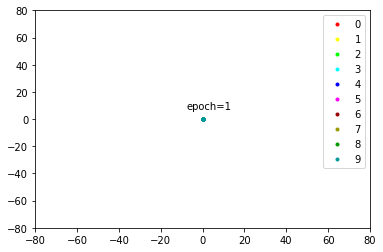

---- epoch:1 ------
   [train] Average loss: 1.7941, acc: 15.02%


---- epoch:2 ------
   [train] Average loss: 1.5878, acc: 25.00%


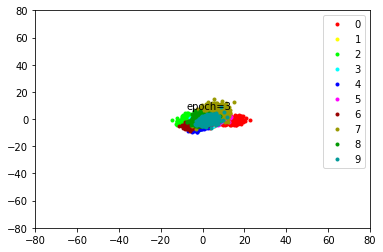

---- epoch:3 ------
   [train] Average loss: 0.9073, acc: 56.30%


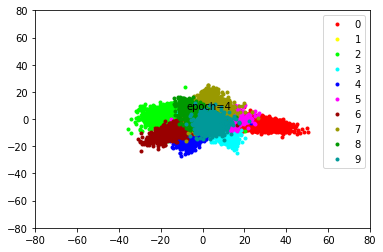

---- epoch:4 ------
   [train] Average loss: 0.6586, acc: 68.09%


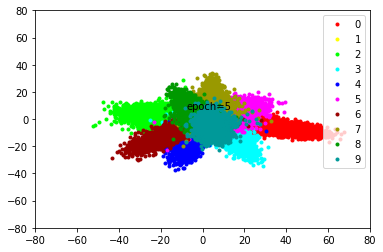

---- epoch:5 ------
   [train] Average loss: 0.5623, acc: 79.17%


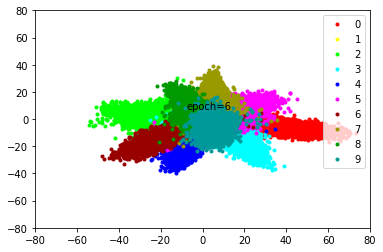

---- epoch:6 ------
   [train] Average loss: 0.5242, acc: 81.95%


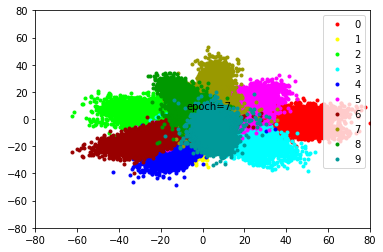

---- epoch:7 ------
   [train] Average loss: 0.3492, acc: 89.31%


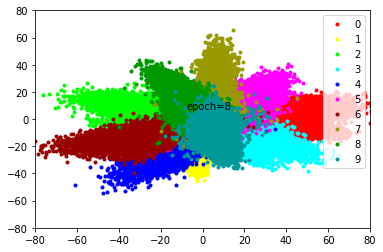

---- epoch:8 ------
   [train] Average loss: 0.2569, acc: 92.20%


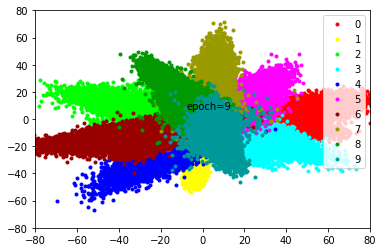

---- epoch:9 ------
   [train] Average loss: 0.2011, acc: 93.89%


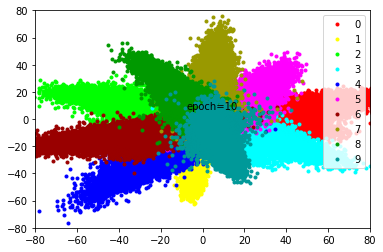

---- epoch:10 ------
   [train] Average loss: 0.1602, acc: 95.03%


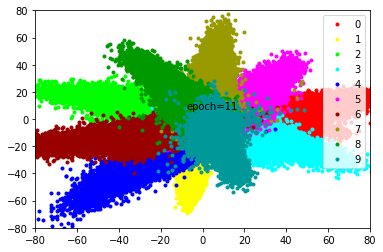

---- epoch:11 ------
   [train] Average loss: 0.1313, acc: 95.80%


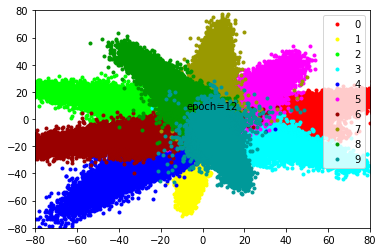

---- epoch:12 ------
   [train] Average loss: 0.1099, acc: 96.56%


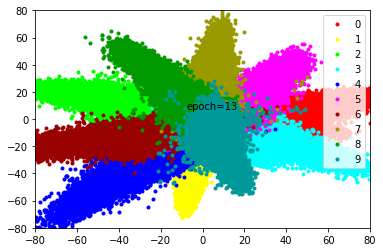

---- epoch:13 ------
   [train] Average loss: 0.1010, acc: 96.85%


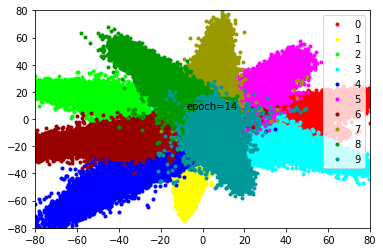

---- epoch:14 ------
   [train] Average loss: 0.1858, acc: 93.82%


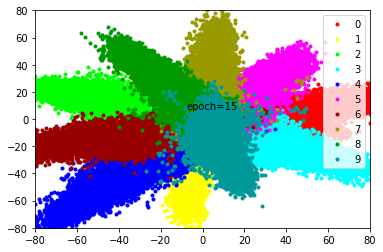

---- epoch:15 ------
   [train] Average loss: 0.1433, acc: 95.31%


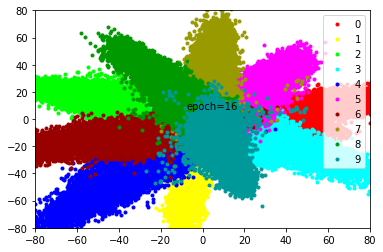

---- epoch:16 ------
   [train] Average loss: 0.1173, acc: 96.08%


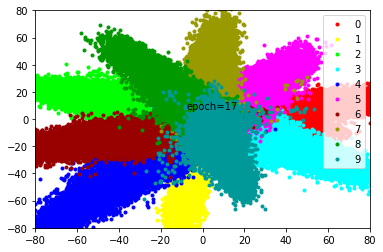

---- epoch:17 ------
   [train] Average loss: 0.0954, acc: 96.73%


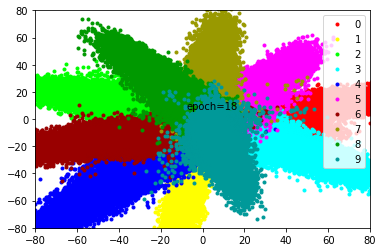

---- epoch:18 ------
   [train] Average loss: 0.0782, acc: 97.28%


---- epoch:19 ------
   [train] Average loss: 0.0636, acc: 97.68%


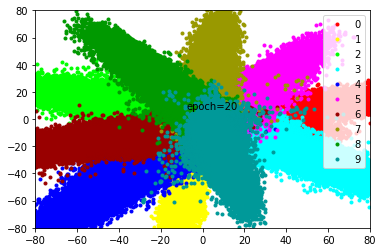

---- epoch:20 ------
   [train] Average loss: 0.0523, acc: 98.08%


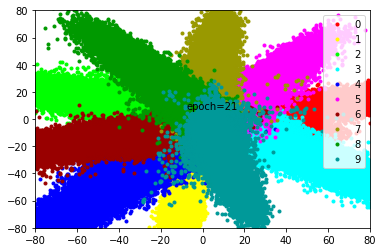

---- epoch:21 ------
   [train] Average loss: 0.0402, acc: 98.61%


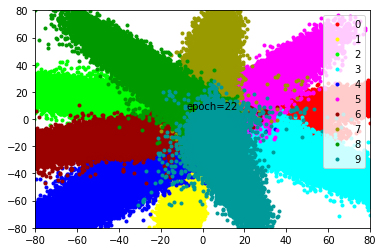

---- epoch:22 ------
   [train] Average loss: 0.0293, acc: 99.00%


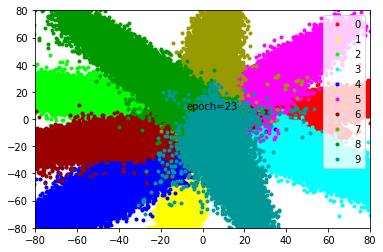

---- epoch:23 ------
   [train] Average loss: 0.0202, acc: 99.42%


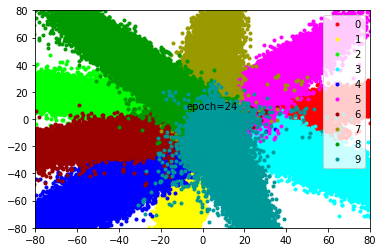

---- epoch:24 ------
   [train] Average loss: 0.0152, acc: 99.66%


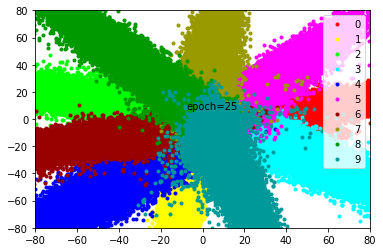

---- epoch:25 ------
   [train] Average loss: 0.0120, acc: 99.78%


---- epoch:26 ------
   [train] Average loss: 0.0103, acc: 99.85%


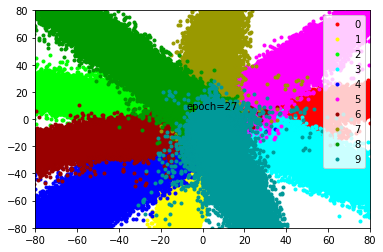

---- epoch:27 ------
   [train] Average loss: 0.0094, acc: 99.88%


---- epoch:28 ------
   [train] Average loss: 0.0089, acc: 99.91%


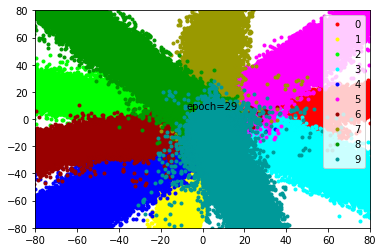

---- epoch:29 ------
   [train] Average loss: 0.0087, acc: 99.91%


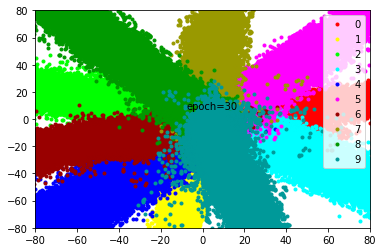

---- epoch:30 ------
   [train] Average loss: 0.0692, acc: 97.28%


---- epoch:31 ------
   [train] Average loss: 0.0648, acc: 97.61%


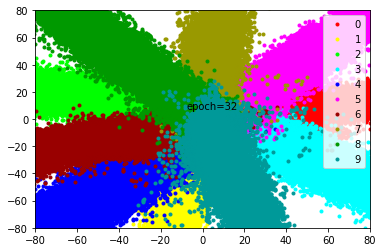

---- epoch:32 ------
   [train] Average loss: 0.0543, acc: 97.93%


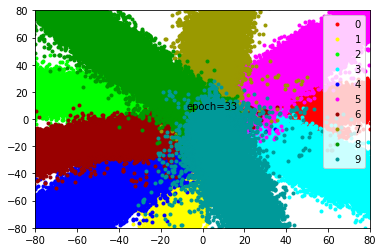

---- epoch:33 ------
   [train] Average loss: 0.0352, acc: 98.63%


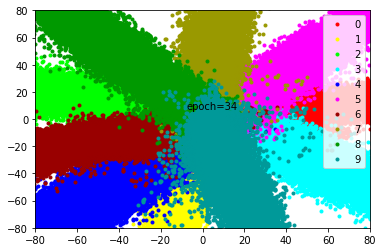

---- epoch:34 ------
   [train] Average loss: 0.0334, acc: 98.69%


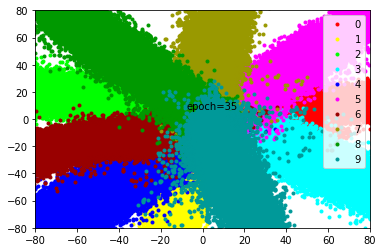

---- epoch:35 ------
   [train] Average loss: 0.0267, acc: 98.94%


---- epoch:36 ------
   [train] Average loss: 0.0254, acc: 99.00%


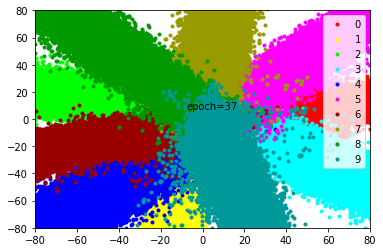

---- epoch:37 ------
   [train] Average loss: 0.0216, acc: 99.16%


---- epoch:38 ------
   [train] Average loss: 0.0164, acc: 99.31%


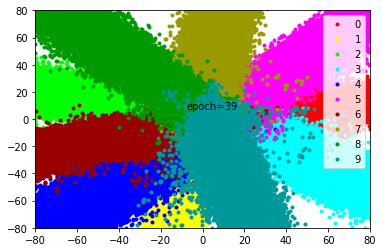

---- epoch:39 ------
   [train] Average loss: 0.0137, acc: 99.45%


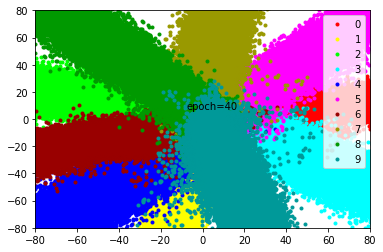

---- epoch:40 ------
   [train] Average loss: 0.0077, acc: 99.77%


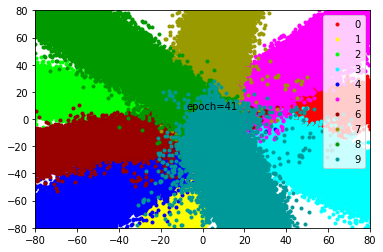

---- epoch:41 ------
   [train] Average loss: 0.0057, acc: 99.83%


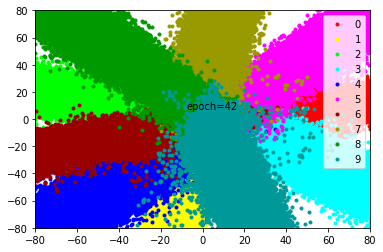

---- epoch:42 ------
   [train] Average loss: 0.0033, acc: 99.93%


---- epoch:43 ------
   [train] Average loss: 0.0022, acc: 99.98%


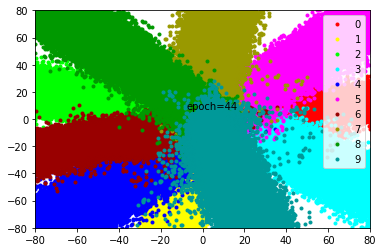

---- epoch:44 ------
   [train] Average loss: 0.0018, acc: 99.97%


---- epoch:45 ------
   [train] Average loss: 0.0014, acc: 99.99%


---- epoch:46 ------
   [train] Average loss: 0.0011, acc: 100.00%


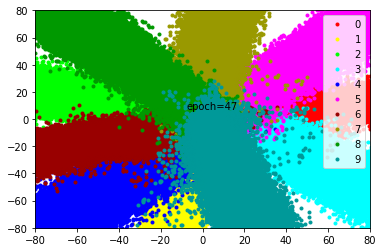

---- epoch:47 ------
   [train] Average loss: 0.0010, acc: 100.00%


---- epoch:48 ------
   [train] Average loss: 0.0009, acc: 100.00%


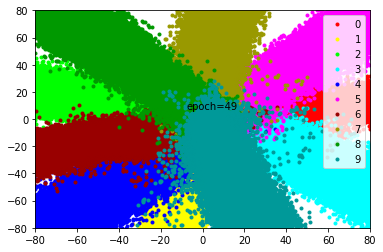

---- epoch:49 ------
   [train] Average loss: 0.0008, acc: 100.00%


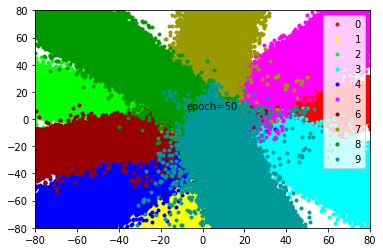

---- epoch:50 ------
   [train] Average loss: 0.0008, acc: 100.00%


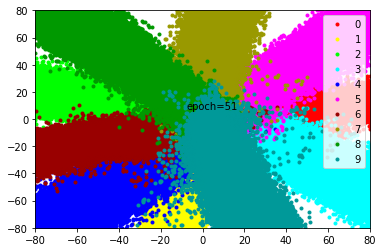

---- epoch:51 ------
   [train] Average loss: 0.0008, acc: 100.00%


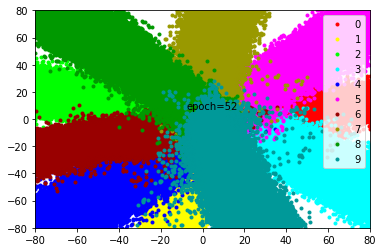

---- epoch:52 ------
   [train] Average loss: 0.0008, acc: 100.00%


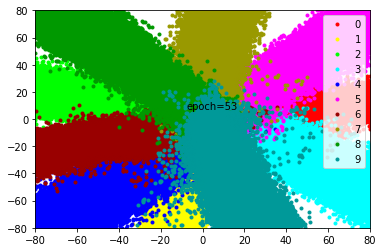

---- epoch:53 ------
   [train] Average loss: 0.0007, acc: 100.00%


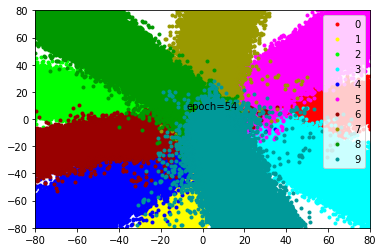

---- epoch:54 ------
   [train] Average loss: 0.0007, acc: 100.00%


---- epoch:55 ------
   [train] Average loss: 0.0007, acc: 100.00%


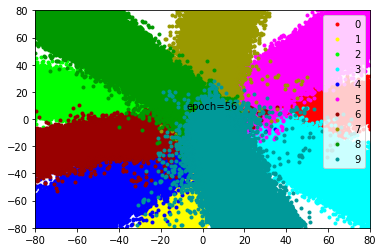

---- epoch:56 ------
   [train] Average loss: 0.0007, acc: 100.00%


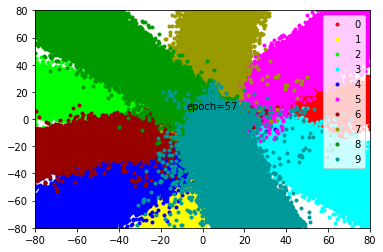

---- epoch:57 ------
   [train] Average loss: 0.0007, acc: 100.00%


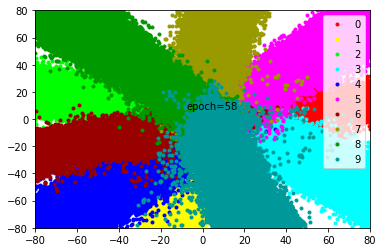

---- epoch:58 ------
   [train] Average loss: 0.0007, acc: 100.00%


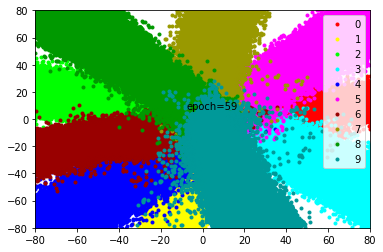

---- epoch:59 ------
   [train] Average loss: 0.0007, acc: 100.00%


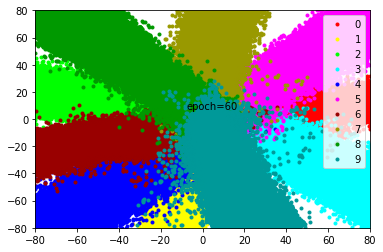

---- epoch:60 ------
   [train] Average loss: 0.0007, acc: 100.00%


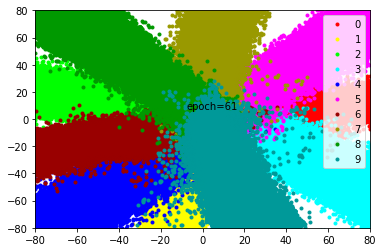

---- epoch:61 ------
   [train] Average loss: 0.0007, acc: 100.00%


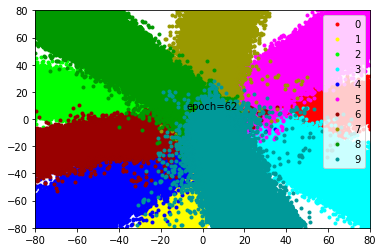

---- epoch:62 ------
   [train] Average loss: 0.0008, acc: 100.00%


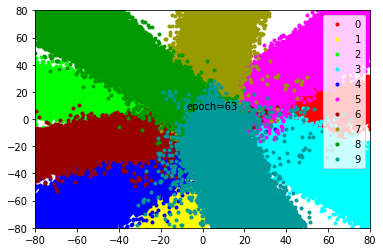

---- epoch:63 ------
   [train] Average loss: 0.0043, acc: 99.88%


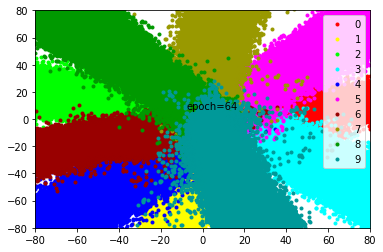

---- epoch:64 ------
   [train] Average loss: 0.0469, acc: 98.11%


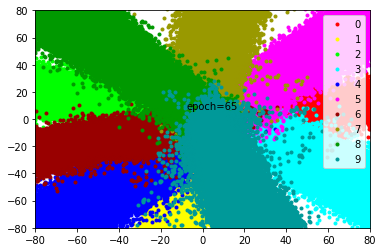

---- epoch:65 ------
   [train] Average loss: 0.0277, acc: 98.90%


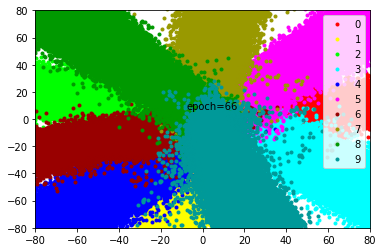

---- epoch:66 ------
   [train] Average loss: 0.0184, acc: 99.21%


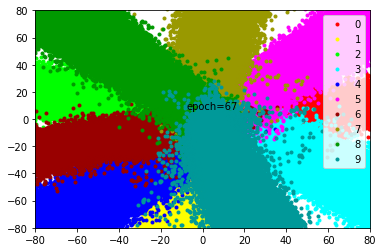

---- epoch:67 ------
   [train] Average loss: 0.0134, acc: 99.48%


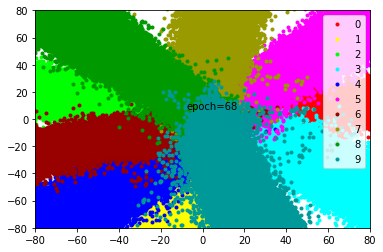

---- epoch:68 ------
   [train] Average loss: 0.0117, acc: 99.55%


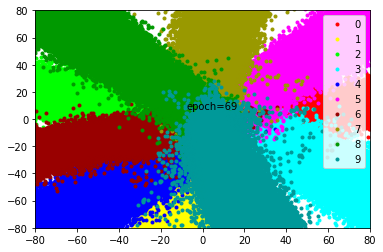

---- epoch:69 ------
   [train] Average loss: 0.0104, acc: 99.59%


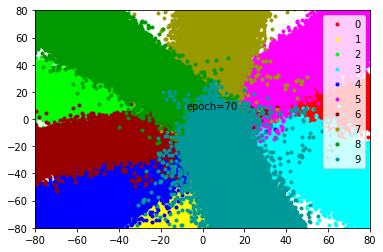

---- epoch:70 ------
   [train] Average loss: 0.0083, acc: 99.69%


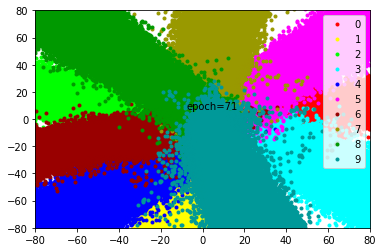

---- epoch:71 ------
   [train] Average loss: 0.0111, acc: 99.55%


---- epoch:72 ------
   [train] Average loss: 0.0099, acc: 99.61%


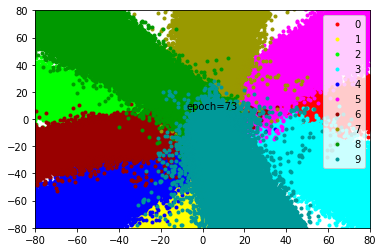

---- epoch:73 ------
   [train] Average loss: 0.0072, acc: 99.71%


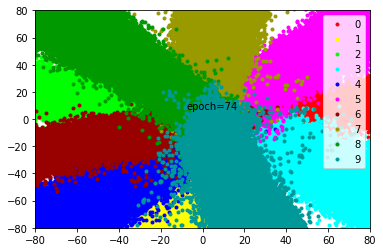

---- epoch:74 ------
   [train] Average loss: 0.0048, acc: 99.85%


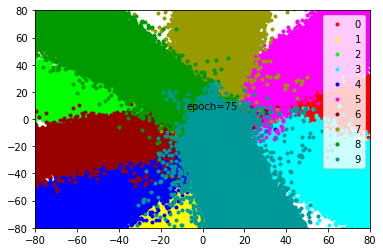

---- epoch:75 ------
   [train] Average loss: 0.0046, acc: 99.84%


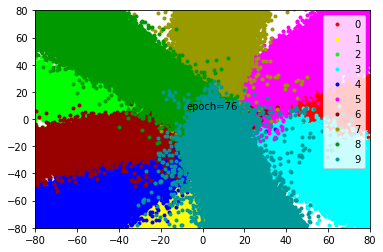

---- epoch:76 ------
   [train] Average loss: 0.0032, acc: 99.90%


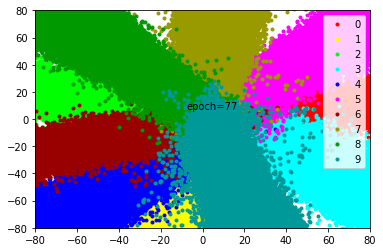

---- epoch:77 ------
   [train] Average loss: 0.0020, acc: 99.95%


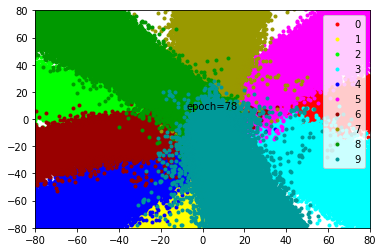

---- epoch:78 ------
   [train] Average loss: 0.0014, acc: 99.97%


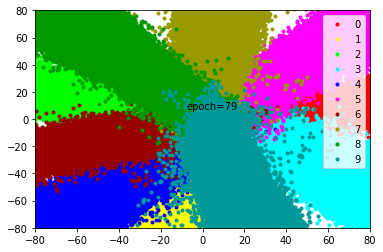

---- epoch:79 ------
   [train] Average loss: 0.0013, acc: 99.97%


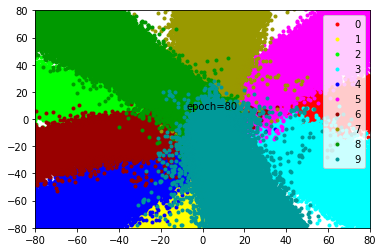

---- epoch:80 ------
   [train] Average loss: 0.0006, acc: 100.00%


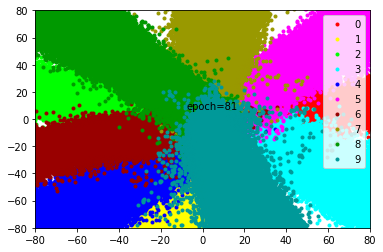

---- epoch:81 ------
   [train] Average loss: 0.0005, acc: 100.00%


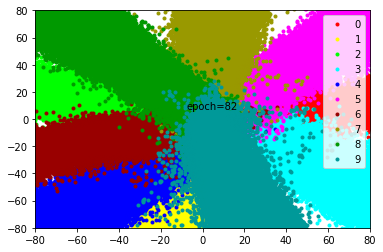

---- epoch:82 ------
   [train] Average loss: 0.0006, acc: 99.99%


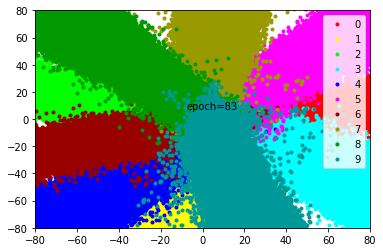

---- epoch:83 ------
   [train] Average loss: 0.0005, acc: 100.00%


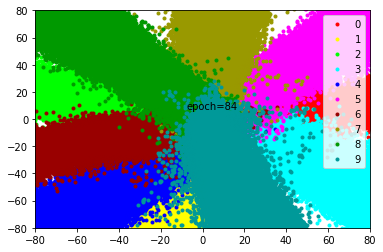

---- epoch:84 ------
   [train] Average loss: 0.0004, acc: 100.00%


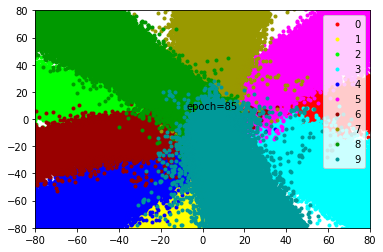

---- epoch:85 ------
   [train] Average loss: 0.0005, acc: 100.00%


KeyboardInterrupt: 

In [15]:
model = Net() #LeNet()
learner = Learner(model, data_loader_train)
learner.fit(model_loss_func, 0.002, num_epochs=100, callbacks=[plottracker, CenterLossOptimHook()])